# Project 2

In [254]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LassoLarsCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, Imputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV,cross_val_score, train_test_split, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from jupyterthemes import jtplot
jtplot.style()
sns.despine(top=True, right=True)
%matplotlib inline


In [255]:
# Standard eda operations in a function
def datachecks(df):
    display('__'*len(df.columns))

    display("HEAD", df.head(3))
    display("TAIL", df.tail(3))
    display(df.dtypes)

    display('__'*len(df.columns))

    def gotnulls(df):

        # no personality
        if df.isnull().sum().sum() > 1:
            print('NULL COLUMNS: ')
            print([
                print(x, ' : ',
                      df[x].dtype) for x in train.columns[train.isnull().any()]],
                  '\n')

    def whodat(df):

        # column, explain yourself
        werd = df.select_dtypes(include=["object"]).columns
        numbahs = df.select_dtypes(include=["int", "float64"]).columns
        boules = df.select_dtypes(include=["bool"]).columns

        # watch out for those non-numerics
        if len(werd) >= 1:
            print(f'\n\n There are {len(werd)} non-numeric columns \n\n')
            display(train.describe(include=[np.object]).T)

        elif len(boules) >= 1:
            print(f'\n\n There are {len(werd)} boolean columns: \n\n')
            print(train.describe(include=['bool']).T)

        print(f'\n\n {len(numbahs)} Numeric columns: \n\n')
        display(train.describe(include=[np.number]).T)

    return gotnulls(df), whodat(df)
    return "INFO", df.info(memory_usage='deep')
    print(df.shape, df.columns)

In [256]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(30,20))

    # Generate a mask for the upper triangle (taken from the Seaborn example gallery):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with Seaborn.
    # Assign the matplotlib axis the function returns. This allow us to resize the labels.
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corrs, mask=mask, annot=False, cmap=cmap, vmin=-1, vmax=1)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

    

In [257]:
def columntypes(df):
    # object features
    obj_cols = [x for x in df.columns if df[x].dtype == object]
    # features with nulls
    null_columns = [x for x in train.columns[train.isnull().any()]]
    # objects with nulls
    obj_nulls = [x for x in obj_cols if x in null_columns]
    # numeric features
    num_cols = [x for x in df.select_dtypes(include=["int", "float64"]).columns]
    # numeric features with nulls
    num_nulls = [x for x in num_cols if x in null_columns]

    return {"nulls":null_columns, "objects":obj_cols, "null objects": obj_nulls,
            "nums":num_cols,"null num": num_nulls}
    
#     return "\n\n\n NULL: \n\n\n",null_columns, len(null_columns)
#     return "n\n\n OBJ: \n\n\n",obj_cols, len(obj_cols)
#     return "n\n\n OBJ NULL: \n\n\n",obj_nulls, len(obj_nulls)
#     return "n\n\n NUM: \n\n\n",num_cols, len(num_cols)
#     return "n\n\n NUM NULL: \n\n\n",num_nulls, len(num_nulls)

In [258]:
# Load in 'train' and 'test' data.
train = pd.read_csv("train.csv")
print("Train set: \n", train.shape, "\n Columns: \n", train.columns)
test = pd.read_csv("test.csv")
print("test set: \n", test.shape, "\n Columns: \n", test.columns)

# SalePrice is our target
price = train['SalePrice']
# Natural log transformation of target, ascribe equal weight to errors 
# Ref: https://people.duke.edu/~rnau/411log.htm
y = np.log1p(price)

print("Differing columns: \n", [x for x in train.columns if x not in test.columns])
print("Duplicate entries: ", train.shape[0] - len(set(train['Id'])))    
# print("Duplicate IDs: \n", [x for x in train.Id if x in test.Id])

Train set: 
 (2051, 81) 
 Columns: 
 Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Gar

In [259]:
# Id column isn't needed
X = train.drop(columns='Id')

In [260]:
y.shape, X.shape, test.shape

((2051,), (2051, 80), (879, 80))

In [261]:
# Data Clean-up and Feature Engineering Run

In [262]:
# The Ames, Iowa data dataset documentation states:
# > Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no
# >observations have been removed due to unusual values and all final residential sales
# >from the initial data set are included in the data presented with this article. There are
# >five observations that an instructor may wish to remove from the data set before giving
# >it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
# >points). Three of them are true outliers (Partial Sales that likely don’t represent actual
# >market values) and two of them are simply unusual sales (very large houses priced
# >relatively appropriately). I would recommend removing any houses with more than
# >4000 square feet from the data set (which eliminates these five unusual observations)
# >before assigning it to students. 
# >>Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
# >>Cock, D. De. (2011). Ames , Iowa : Alternative to the Boston Housing Data as an End of Semester Regression Project. Journal of Statistics >>Education, 19(3), 1–15. Retrieved from www.amstat.org/publications/jse/v19n3/decock.pdf

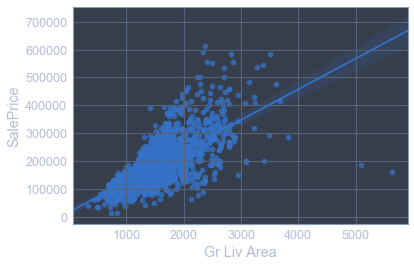

In [263]:
sns.regplot(X['Gr Liv Area'], X['SalePrice'])

In [264]:
# This dataset has the two outliers mentioned in the paper.

X = X[X['Gr Liv Area']<4000]

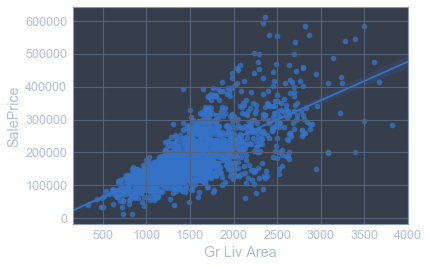

In [265]:
sns.regplot(X['Gr Liv Area'], X['SalePrice'])

In [266]:
# Take log of the target. Taking the log will mean that the errors in predicting
# expensive houses will affect the result equally as the errors in predicting cheap 
# houses. Ref: https://people.duke.edu/~rnau/411log.htm

# X['SalePrice'] = np.log1p(X['SalePrice'])
y = np.log1p(X['SalePrice'])

In [267]:
# DATADICT, lets see what objects we can clean up
datadict = {}
rankables = []
rankcol = []
for x in columntypes(X)['objects']:
        
    datadict.update({x : np.ndarray.tolist(X[x].unique())})
for key,value in sorted(datadict.items()):
    if key != 'PID':
        print(key, "\n", value, "\n")
        rankables.append([x for x in value])
        rankcol.append(key)

Alley 
 [nan, 'Pave', 'Grvl'] 

Bldg Type 
 ['1Fam', 'TwnhsE', 'Twnhs', '2fmCon', 'Duplex'] 

Bsmt Cond 
 ['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'] 

Bsmt Exposure 
 ['No', 'Gd', 'Av', nan, 'Mn'] 

Bsmt Qual 
 ['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'] 

BsmtFin Type 1 
 ['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'] 

BsmtFin Type 2 
 ['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'] 

Central Air 
 ['Y', 'N'] 

Condition 1 
 ['RRAe', 'Norm', 'PosA', 'Artery', 'Feedr', 'PosN', 'RRAn', 'RRNe', 'RRNn'] 

Condition 2 
 ['Norm', 'RRNn', 'Feedr', 'Artery', 'PosA', 'PosN', 'RRAe', 'RRAn'] 

Electrical 
 ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'] 

Exter Cond 
 ['TA', 'Gd', 'Fa', 'Ex', 'Po'] 

Exter Qual 
 ['Gd', 'TA', 'Ex', 'Fa'] 

Exterior 1st 
 ['HdBoard', 'VinylSd', 'Wd Sdng', 'BrkFace', 'Plywood', 'MetalSd', 'AsbShng', 'CemntBd', 'WdShing', 'Stucco', 'BrkComm', 'Stone', 'CBlock', 'ImStucc', 'AsphShn'] 

Exterior 2nd 
 ['Plywood', 'VinylSd', 'Wd Sdng', 'HdBoard', 'MetalSd', 'AsbShng', 'CmentBd', 'Wd 

In [268]:
'''
Alley - NAN = NOT THERE, RANK
 [nan, 'Pave', 'Grvl'] 

Bldg Type 
 ['1Fam', 'TwnhsE', 'Twnhs', '2fmCon', 'Duplex'] 

Bsmt Cond - NAN = 0, RANK
 ['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'] 

Bsmt Exposure - NAN = 0, RANK
 ['No', 'Gd', 'Av', nan, 'Mn'] 

Bsmt Qual - NAN = 0, RANK
 ['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'] 

BsmtFin Type 1 - NAN = 0, COMBINE WITH TYPE 2, RANK
 ['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'] 

BsmtFin Type 2 
 ['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'] 

Central Air - BINARY!
 ['Y', 'N'] 

Condition 1 - COMBINE
 ['RRAe', 'Norm', 'PosA', 'Artery', 'Feedr', 'PosN', 'RRAn', 'RRNe', 'RRNn'] 

Condition 2 
 ['Norm', 'RRNn', 'Feedr', 'Artery', 'PosA', 'PosN', 'RRAe', 'RRAn'] 

Electrical 
 ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'] 

Exter Cond - RANK 0 - 5
 ['TA', 'Gd', 'Fa', 'Ex', 'Po'] 

Exter Qual - RANK 0 - 5
 ['Gd', 'TA', 'Ex', 'Fa'] 

Exterior 1st - COMBINE
 ['HdBoard', 'VinylSd', 'Wd Sdng', 'BrkFace', 'Plywood', 'MetalSd', 'AsbShng', 'CemntBd', 'WdShing', 'Stucco', 'BrkComm', 'Stone', 'CBlock', 'ImStucc', 'AsphShn'] 

Exterior 2nd - COMBINE
 ['Plywood', 'VinylSd', 'Wd Sdng', 'HdBoard', 'MetalSd', 'AsbShng', 'CmentBd', 'Wd Shng', 'BrkFace', 'Stucco', 'Brk Cmn', 'ImStucc', 'Stone', 'CBlock', 'AsphShn'] 

Fence - NAN = NOTTHERE
 [nan, 'MnPrv', 'GdPrv', 'GdWo', 'MnWw'] 

Fireplace Qu - NAN = 0, RANK
 [nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'] 

Foundation 
 ['CBlock', 'PConc', 'BrkTil', 'Slab', 'Stone', 'Wood'] 

Functional RANK??
 ['Typ', 'Mod', 'Min2', 'Maj1', 'Min1', 'Sev', 'Sal', 'Maj2'] 

Garage Cond - NAN = 0, RANK
 ['TA', 'Fa', nan, 'Po', 'Gd', 'Ex'] 

Garage Finish - NAN = NOTTHERE
 ['RFn', 'Unf', 'Fin', nan] 

Garage Qual - NAN = 0, RANK
 ['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'] 

Garage Type - - NAN = NOTTHERE
 ['Attchd', 'Detchd', 'BuiltIn', 'Basment', nan, '2Types', 'CarPort'] 

Heating 
 ['GasA', 'GasW', 'Grav', 'Wall', 'OthW'] 

Heating QC - RANK
 ['Ex', 'TA', 'Gd', 'Fa', 'Po'] 

House Style 
 ['2Story', '1Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin', '1.5Unf'] 

Kitchen Qual - RANK
 ['Gd', 'TA', 'Fa', 'Ex'] 

Land Contour 
 ['Lvl', 'HLS', 'Bnk', 'Low'] 

Land Slope RANK
 ['Gtl', 'Sev', 'Mod'] 

Lot Config 
 ['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3'] 

Lot Shape RANK
 ['IR1', 'Reg', 'IR2', 'IR3'] 

MS Zoning 
 ['RL', 'RM', 'FV', 'C (all)', 'A (agr)', 'RH', 'I (all)'] 

Mas Vnr Type - NAN = NONE
 ['BrkFace', 'None', nan, 'Stone', 'BrkCmn'] 

Misc Feature - - NAN = NOTTHERE
 [nan, 'Shed', 'TenC', 'Gar2', 'Othr', 'Elev'] 

Neighborhood 
 ['Sawyer', 'SawyerW', 'NAmes', 'Timber', 'Edwards', 'OldTown', 'BrDale', 'CollgCr', 'Somerst', 'Mitchel', 'StoneBr', 'NridgHt', 'Gilbert', 'Crawfor', 'IDOTRR', 'NWAmes', 'Veenker', 'MeadowV', 'SWISU', 'NoRidge', 'ClearCr', 'Blmngtn', 'BrkSide', 'NPkVill', 'Blueste', 'GrnHill', 'Greens', 'Landmrk'] 

Paved Drive - RANK, 0, 1, 2
 ['Y', 'N', 'P'] 

Pool QC - - NAN = 0, RANK
 [nan, 'Fa', 'Gd', 'Ex', 'TA'] 

Roof Matl 
 ['CompShg', 'WdShngl', 'Tar&Grv', 'WdShake', 'Membran', 'ClyTile'] 

Roof Style 
 ['Gable', 'Hip', 'Flat', 'Mansard', 'Shed', 'Gambrel'] 

Sale Type 
 ['WD ', 'New', 'COD', 'ConLD', 'Con', 'CWD', 'Oth', 'ConLI', 'ConLw'] 

Street - RANK
 ['Pave', 'Grvl'] 

Utilities RANK
 ['AllPub', 'NoSeWa', 'NoSewr'] 
'''

"\nAlley - NAN = NOT THERE, RANK\n [nan, 'Pave', 'Grvl'] \n\nBldg Type \n ['1Fam', 'TwnhsE', 'Twnhs', '2fmCon', 'Duplex'] \n\nBsmt Cond - NAN = 0, RANK\n ['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'] \n\nBsmt Exposure - NAN = 0, RANK\n ['No', 'Gd', 'Av', nan, 'Mn'] \n\nBsmt Qual - NAN = 0, RANK\n ['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'] \n\nBsmtFin Type 1 - NAN = 0, COMBINE WITH TYPE 2, RANK\n ['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'] \n\nBsmtFin Type 2 \n ['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'] \n\nCentral Air - BINARY!\n ['Y', 'N'] \n\nCondition 1 - COMBINE\n ['RRAe', 'Norm', 'PosA', 'Artery', 'Feedr', 'PosN', 'RRAn', 'RRNe', 'RRNn'] \n\nCondition 2 \n ['Norm', 'RRNn', 'Feedr', 'Artery', 'PosA', 'PosN', 'RRAe', 'RRAn'] \n\nElectrical \n ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'] \n\nExter Cond - RANK 0 - 5\n ['TA', 'Gd', 'Fa', 'Ex', 'Po'] \n\nExter Qual - RANK 0 - 5\n ['Gd', 'TA', 'Ex', 'Fa'] \n\nExterior 1st - COMBINE\n ['HdBoard', 'VinylSd', 'Wd Sdng', 'BrkFace', 'Plywood', 'MetalS

In [271]:
def obj_ranker(df):

    objects = columntypes(df)['objects']
    df[objects] = df[objects].replace(["No", "N"], 0)

    df[objects] = df[objects].replace(["P", "Grvl", "Po", "Mn", "Unf",
                                       "Sal", "Sev", "IR3"], 1)
    df[objects] = df[objects].replace(["Y", "Fa", "Pave", "LwQ", "IR2",
                                       "NoSeWa"], 2)

    df[objects] = df[objects].replace(["Av", "TA", "Rec", "Maj2", "Gtl",
                                       "IR1", "NoSewr"], 3)

    df[objects] = df[objects].replace(["Gd", "AllPub", "Reg", "Maj1", "BLQ"], 4)

    df[objects] = df[objects].replace(["ALQ", "Mod", "Ex"], 5)

    df[objects] = df[objects].replace(["Min2","GLQ"], 6)
    df[objects] = df[objects].replace("Min1", 7)
    df[objects] = df[objects].replace("Typ", 8)
    
    for x in rankcol:
        df[x] = df[x].fillna(0)
    

In [272]:
obj_ranker(X)

In [273]:
X[rankcol]

,Alley,Bldg Type,Bsmt Cond,Bsmt Exposure,Bsmt Qual,BsmtFin Type 1,BsmtFin Type 2,Central Air,Condition 1,Condition 2,...,Mas Vnr Type,Misc Feature,Neighborhood,Paved Drive,Pool QC,Roof Matl,Roof Style,Sale Type,Street,Utilities
0,0.0,1Fam,3.0,0.0,3.0,6.0,1.0,2,RRAe,Norm,...,BrkFace,0,Sawyer,2,0.0,CompShg,Gable,WD,2,4
1,0.0,1Fam,3.0,0.0,4.0,6.0,1.0,2,Norm,Norm,...,BrkFace,0,SawyerW,2,0.0,CompShg,Gable,WD,2,4
2,0.0,1Fam,3.0,0.0,3.0,6.0,1.0,2,Norm,Norm,...,None,0,NAmes,2,0.0,CompShg,Gable,WD,2,4
3,0.0,1Fam,3.0,0.0,4.0,1.0,1.0,2,Norm,Norm,...,None,0,Timber,2,0.0,CompShg,Gable,WD,2,4
4,0.0,1Fam,4.0,0.0,2.0,1.0,1.0,2,Norm,Norm,...,None,0,SawyerW,0,0.0,CompShg,Gable,WD,2,4
5,0.0,1Fam,3.0,0.0,3.0,5.0,3.0,2,PosA,Norm,...,None,0,NAmes,2,0.0,CompShg,Gable,WD,2,4
6,0.0,TwnhsE,3.0,4.0,4.0,6.0,1.0,2,Norm,Norm,...,BrkFace,0,Edwards,2,0.0,CompShg,Gable,New,2,4
7,0.0,1Fam,3.0,0.0,3.0,3.0,1.0,2,Norm,Norm,...,BrkFace,0,NAmes,2,0.0,CompShg,Hip,COD,2,4
8,0.0,1Fam,3.0,0.0,3.0,3.0,1.0,2,Artery,Norm,...,None,Shed,OldTown,2,0.0,CompShg,Gable,WD,2,4
9,0.0,1Fam,3.0,3.0,4.0,3.0,1.0,2,Norm,Norm,...,BrkFace,0,NAmes,2,0.0,CompShg,Gable,WD,2,4


In [204]:
ranks = ["P", "Grvl", "Po", "Mn", "Unf", "Sal", "Sev", "IR3","Y", "Fa", "Pave", "LwQ", "IR2", "NoSeWa","Av", "TA", "Rec", "Maj2", "Gtl", "IR1", "NoSewr","Gd", "AllPub", "Reg", "Maj1", "BLQ","ALQ", "Mod", "Ex"]


In [101]:
# objects = columntypes(df)['objects']
# rankables = []
# ranks = ['Ex','Gd','TA','Fa','Po','Mn','Av']
# rancor = [rankables.append(x) for x in df.columns if ranks in X[objects]]

# for x in 

TypeError: unhashable type: 'list'

In [91]:
# ''' 
# ## Rankable features
# Pool QC  :  [nan 'TA' 'Fa' 'Gd' 'Ex']
# {"No" : 0, "Po" : 1,"Mn":1, "Fa" : 2, "Av": 3, TA" : 3, "Gd" : 4, "Ex" : 5}
# # rankcols = []
# # for x in df[obj_cols]:
# #     if 'Ex' in df[x].unique():
# #         rankcols.append(x)
# # #     print(x, " : ", df[x].unique())
# # df.replace(['Ex','Gd','TA','Fa','Po'],[5, 4, 3, 2, 1], inplace=True)
# # df[rankcols] = df[rankcols].fillna(0)

# rankables = []
# rancor = [rankables.append(x) for x in df[obj_cols] if 'Ex' in df[x].unique()]
# ranks = ['Ex','Gd','TA','Fa','Po']
# rankables

# for x in df.columns:
#     df[x].replace(['Ex','Gd','TA','Fa','Po'],[5, 4, 3, 2, 1], inplace=True)
# df[rankables] = df[rankables].fillna(0)

# df['GarageMeta'] = df["Garage Cond"] + df["Garage Qual"]

# df['ExteriorMeta'] = df['Exter Cond'] + df['Exter Qual']

# df['BsmtMeta'] = df['Bsmt Cond'] + df['Bsmt Qual']

# df['BsmtFinSF'] = df['BsmtFin SF 1'] + df['BsmtFin SF 2']
# df['BsmtBath'] = df['Bsmt Full Bath'] + df['Bsmt Half Bath']

# df.drop(columns=['Exter Qual',
#                  'Exter Cond',
#                  'Bsmt Qual',
#                  'Bsmt Cond',
#                  'Garage Qual',
#                  'Garage Cond',
#                  'Garage Yr Blt',
#                  'Year Built',
#                  'Year Remod/Add',
#                 'Bsmt Full Bath',
#                 'Bsmt Half Bath',
#                 'Yr Sold',
#                 'Mo Sold',
#                 'BsmtFin SF 1',
#                  'BsmtFin SF 2'], inplace=True)
# # taking out year features because i cant deal with this right now

# df.shape'''
# def ranker(df):
#     objects = columntypes(df)['objects']
#     rankables = []
#     ranks = ['Ex','Gd','TA','Fa','Po','Mn','Av']
#     rancor = [rankables.append(x) 
#         for x in df.columns if ranks in df[x]]
    
#     for x in df.columns:
              
#               df[objects] = df[objects].replace({ x : {"No" : 0, 
#                                                  "Po" : 1,
#                                                  "Mn":1,
#                                                  "Fa" : 2,
#                                                  "Av": 3,
#                                                  "TA" : 3,
#                                                  "Gd" : 4,
#                                                  "Ex" : 5}})
#     df[rankables] = df[rankables].fillna(0)


In [92]:
ranker(df)


TypeError: unhashable type: 'list'

In [84]:
df["Alley"].value_counts()

Grvl    85
Pave    55
Name: Alley, dtype: int64

In [56]:
for x in df[columntypes(df)['objects']]:
    testin.replace({ x : {"No" : 0, 
                         "Po" : 11111,
                         "Mn":11,
                         "Fa" : 222,
                         "Av": 3333,
                         "TA" : 32,
                         "Gd" : 4444,
                         "Ex" : 5555}}, inplace=True)
    print(testin['Bsmt Exposure'])
                        

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       4.0
7       0.0
8       0.0
9       3.0
10      0.0
11      3.0
12      NaN
13      0.0
14      3.0
15      3.0
16      0.0
17      0.0
18      0.0
19      1.0
20      0.0
21      0.0
22      3.0
23      0.0
24      1.0
25      0.0
26      0.0
27      0.0
28      0.0
29      1.0
       ... 
2021    3.0
2022    3.0
2023    0.0
2024    0.0
2025    4.0
2026    0.0
2027    0.0
2028    0.0
2029    4.0
2030    1.0
2031    0.0
2032    0.0
2033    3.0
2034    4.0
2035    0.0
2036    0.0
2037    0.0
2038    4.0
2039    0.0
2040    0.0
2041    3.0
2042    0.0
2043    1.0
2044    0.0
2045    3.0
2046    3.0
2047    0.0
2048    0.0
2049    0.0
2050    0.0
Name: Bsmt Exposure, Length: 2051, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       4.0
7       0.0
8       0.0
9       3.0
10      0.0
11      3.0
12      NaN
13      0.0
14      3.0
15      3.0
16      0.0
17      0.0
18

Name: Bsmt Exposure, Length: 2051, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       4.0
7       0.0
8       0.0
9       3.0
10      0.0
11      3.0
12      NaN
13      0.0
14      3.0
15      3.0
16      0.0
17      0.0
18      0.0
19      1.0
20      0.0
21      0.0
22      3.0
23      0.0
24      1.0
25      0.0
26      0.0
27      0.0
28      0.0
29      1.0
       ... 
2021    3.0
2022    3.0
2023    0.0
2024    0.0
2025    4.0
2026    0.0
2027    0.0
2028    0.0
2029    4.0
2030    1.0
2031    0.0
2032    0.0
2033    3.0
2034    4.0
2035    0.0
2036    0.0
2037    0.0
2038    4.0
2039    0.0
2040    0.0
2041    3.0
2042    0.0
2043    1.0
2044    0.0
2045    3.0
2046    3.0
2047    0.0
2048    0.0
2049    0.0
2050    0.0
Name: Bsmt Exposure, Length: 2051, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       4.0
7       0.0
8       0.0
9       3.0
10      0.0
11      3.0
12      NaN
13      0.0


In [ ]:
# object features
obj_cols = [x for x in df.columns if df[x].dtype == object]
# features with nulls
null_columns = [x for x in train.columns[train.isnull().any()]]
# objects with nulls
obj_nulls = [x for x in obj_cols if x in null_columns]
# numeric features
num_cols = [x for x in df.select_dtypes(include=["int", "float64"]).columns]
# numeric features with nulls
num_nulls = [x for x in num_cols if x in null_columns]

print("\n\n\n NULL: \n\n\n",null_columns, len(null_columns))
print("\n\n\n OBJ: \n\n\n",obj_cols, len(obj_cols))
print("\n\n\n OBJ NULL: \n\n\n",obj_nulls, len(obj_nulls))
print("\n\n\n NUM: \n\n\n",num_cols, len(num_cols))
print("\n\n\n NUM NULL: \n\n\n",num_nulls, len(num_nulls))

In [ ]:
# Null Objects have been mended, ['Alley', 'Mas Vnr Type', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Garage Type', 'Garage Finish', 'Fence', 'Misc Feature'] remaining

In [ ]:
# 'Alley', 'Mas Vnr Type', 'Bsmt Exposure', 'BsmtFin Type 1', 
# 'BsmtFin Type 2', 'Garage Type', 'Garage Finish', 'Fence', --> NaN means NotThere
NotThere = ['Alley', 'Mas Vnr Type', 'Bsmt Exposure', 'BsmtFin Type 1', 
            'BsmtFin Type 2', 'Garage Type', 'Garage Finish', 'Fence', 
            'Misc Feature']

for x in NotThere:
    df[x].fillna('NotThere', inplace=True)
df.info()



In [ ]:
# object features
obj_cols = [x for x in df.columns if df[x].dtype == object]
# features with nulls
null_columns = [x for x in train.columns[train.isnull().any()]]
# objects with nulls
obj_nulls = [x for x in obj_cols if x in null_columns]
# numeric features










































num_cols = [x for x in df.select_dtypes(include=["int", "float64"]).columns]
# numeric features with nulls
num_nulls = [x for x in num_cols if x in null_columns]

print("\n\n\n NULL: \n\n\n",null_columns, len(null_columns))
print("\n\n\n OBJ: \n\n\n",obj_cols, len(obj_cols))
print("\n\n\n OBJ NULL: \n\n\n",obj_nulls, len(obj_nulls))
print("\n\n\n NUM: \n\n\n",num_cols, len(num_cols))
print("\n\n\n NUM NULL: \n\n\n",num_nulls, len(num_nulls))

In [ ]:
# obj
df['Quality'] = df['Overall Cond'] + df['Overall Qual']
df.drop(columns=['Overall Cond','Overall Qual', 'PID'], inplace=True)



In [ ]:
df.shape

In [ ]:
df.describe().T # all object columns are filled. numerics can be
                                # filled based on corr. time to split back

In [155]:
def obj_ranker(df):

    objects = columntypes(df)['objects']
    for x in df[objects]:
        df[x] = df[x].replace({x:
                               {
                                   "No": 0,
                                   "N": 0,
                                   "P": 1,
                                   "Grvl": 1,
                                   "Po": 1,
                                   "Mn": 1,
                                   "Unf": 1,
                                   "Sal": 1,
                                   "Sev": 1,
                                   "IR3": 1,
                                   "Y": 2,
                                   "Fa": 2,
                                   "Pave": 2,
                                   "LwQ": 2,
                                   "IR2": 2,
                                   "NoSeWa": 2,
                                   "Av": 3,
                                   "TA": 3,
                                   "Rec": 3,
                                   "Maj2": 3,
                                   "Gtl": 3,
                                   "IR1": 3,
                                   "NoSewr": 3,
                                   "Gd": 4,
                                   "AllPub": 4,
                                   "Reg": 4,
                                   "Maj1": 4,
                                   "BLQ": 4,
                                   "ALQ": 5,
                                   "Mod": 5,
                                   "Ex": 5,
                                   "Min2": 6,
                                   "Min1": 7,
                                   "Typ": 8
                               }
                               }
                              )

In [ ]:
# price = pd.DataFrame(price)

In [ ]:
df.isnull().sum()
df.fillna(0, inplace=True)

going to do corr before train_test_split

In [ ]:
train = df[:len(y)]

In [ ]:
X = train
X.shape, y.shape

In [ ]:
test = df[len(y):]

In [ ]:
test.shape

In [ ]:
# y.Ty.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.75, 
                                                    random_state=19)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
yt_price = pd.DataFrame()
yt_price['SalePrice'] = y_train

In [ ]:
# pd.join([X_train,yt_price])

In [ ]:
# X_testX_train.corrwith(yt_price)
# 

In [ ]:
dfcorr = X_train.reset_index()

In [ ]:
dfcorr=dfcorr.join(yt_price)

In [ ]:
dfcorr

In [ ]:
train.shape

In [ ]:
corr = dfcorr.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

In [ ]:
highcorr=['Kitchen Qual',
        'Gr Liv Area',
        'Total Bsmt SF',
        'Garage Area',
        'Garage Cars',
        '1st Flr SF',
        'ExteriorMeta',
        'Quality',
        'Fireplace Qu',
        'Full Bath',
        'Mas Vnr Area',
        'BsmtMeta',
        'TotRms AbvGrd',
        'Fireplaces',
        ]

In [ ]:
num_corr = [x for x in X_train[highcorr].select_dtypes(include='object').columns]

In [ ]:
X_train = X_train.filter(items=highcorr)
X_train.shape

# woo hoo 23 features!

In [ ]:
X_train

In [ ]:
sns.set(style="white")
corr = X_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(1000, 50, as_cmap=True)
sns.heatmap(corr,annot=True, mask=mask,vmax =.8, cmap=cmap, center=0,fmt= '.2f',
            square=True, linewidths=.1, cbar_kws={"shrink": .5});

In [ ]:
# plot distribution of prices
sns.distplot(y_train)

In [ ]:
y_train_logged = np.log1p(y_train)

In [ ]:
sns.distplot(y_train_logged)

In [ ]:
y_train.shape

In [ ]:
# poly = PolynomialFeatures(include_bias=False)
# X_poly = poly.fit_transform(X_train)

In [ ]:
lr = LinearRegression()
lr.fit(X_poly,y_train)
lr.score(X_poly,y_train)

In [ ]:
poly.get_feature_names(X_train.columns)

In [ ]:
ss = StandardScaler()
ss.fit_transform(X_train)
ss.transform(X_test)

In [ ]:
knn_params = {
    'n_neighbors':[1,3,5,9,15,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

knn_randomsearch = RandomizedSearchCV(KNeighborsRegressor(), knn_params, cv=5, 
                                      n_iter=10, verbose=1, n_jobs=2, random_state=42)

knn_randomsearch = knn_randomsearch.fit(X_train, y_train)

In [ ]:
ss = StandardScaler()
knn = KNeighborsClassifier()

pipe = Pipeline([ #set up tuples for each action, each stage in pipeline is a tuple
    ('ss',ss),  # tuple of (name, action)
    ('knn',knn)
])
# one pipeline is enough, but we're setting up another to to illustrate
# gridsearch
pipe_gs = Pipeline([ #set up tuples for each action, each stage in pipeline is a tuple
    ('ss',ss),  # tuple of (name, action)
    ('knn',knn)
])


In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
pipe.score(X_train, y_train)

In [ ]:
params = {
    'knn__n_neighbors': range(5,11),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}
gs = GridSearchCV(pipe_gs, param_grid=params)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

In [ ]:
gs.score(X_test,y_test)

In [ ]:
# # check the shape. according to instructions, test is missing column='SalePrice'
# train.shape, test.shape

# # Ideally, keep test.csv as a prediction set and build and train model on 
# # the train.csv data
# # Confirm that there isn't a column mismatch between train and test
# # if mismatch detected, then train and test will be concatenated

# print("Matching Columns: ",train.columns.intersection(test.columns))
# print("TrainCSV cols not in TestCSV: ", train.columns.difference(test.columns))
# print("TestCSV cols not in TrainCSV: ", test.columns.difference(train.columns))

# # Looks like the columns are conserved between the train and test sets. 

# X = train.drop(columns='SalePrice')

# y = train.SalePrice.values

# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     train_size=.75,
#                                                     random_state=19) 

# print(X_train.shape,
#      X_test.shape,
#      y_train.shape,
#      y_test.shape)

# # make a deep copy to run EDA on, if successful, X_train will be overwritten
# # with the cleaned df

# df = X_train.copy(deep=True)

# datachecks(df)

# df.shape, df.columns



# # for i in df[obj_cols].iteritems():
# #    print(i)

# tot = (df[obj_nulls].isnull().sum()).sort_values(ascending=False)
# perc = (df[obj_nulls].isnull().sum()/df[obj_nulls].isnull().count()).sort_values(ascending=False)
# missing = pd.concat([tot,perc], axis=1, keys=['Total', 'Percent'])

# garagecols = [x for x in df.filter(regex="^Garage.*", axis=1)]

# garagecols 

# bsmtcols = [x for x in df.filter(regex=".*Bsmt.*", axis=1)]

# bsmtcols

# # for x in missing.index:
# #     print(x, " : ",df[x].unique())

# # for x in missing.index:
# #     print(x, " : ",df[x].unique())

# '''
# ## droppable
# Misc Feature  :  [nan 'Shed' 'Gar2' 'TenC' 'Othr' 'Elev']
# PID

# # binarize / null = none

# [Alley,]  :  [nan 'Grvl' 'Pave']
# [FireplaceQu,]  :  ['Gd' nan 'TA' 'Fa' 'Po' 'Ex']
# [Garage Type,]  :  ['Attchd' '2Types' 'Detchd' 'BuiltIn' 'Basment' nan 'CarPort']
# [GarageFinish,]  :  ['RFn' 'Unf' 'Fin' nan]
# [GarageQual,
# ]  :  ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
# [GarageCond,] 
# :  ['TA' 'Fa' nan 'Po' 'Gd' 'Ex']
# [BsmtExposur
#  e,]  :  ['No' 'Mn' 'Gd' nan 'Av']
# [BsmtCond,] 
# :  ['TA' 'Gd' nan 'Fa' 'Po' 'Ex']
# [BsmtQual,]  :
#     ['Gd' 'Ex' nan 'TA' 'Fa' 'Po']
# [BsmtFinTy
#  pe2,]  :  ['Unf' nan 'LwQ' 'GLQ' 'Rec' 'ALQ' 'BLQ']
# [BsmtFinTy
#  pe1,]  :  ['GLQ' 'ALQ' nan 'Unf' 'BLQ' 'Rec' 'LwQ']
# [MasVnrType,] 
# :  ['Stone' 'None' 'BrkFace' 'BrkCmn' nan 'CBlock']

    

# ['Alley',
# 'FireplaceQu',
# 'GarageType',
# 'GarageFinish',
# 'GarageQual',
# 'GarageCond',
# 'BsmtExposure',
# 'BsmtCond',
# 'BsmtQual',
# 'BsmtFinType2',
# 'BsmtFinType1',
# 'MasVnrType',]

# '''

# df[['Alley','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond']]
# # find features with ranked values like Ex, Gd, etc. convert to numeric scale
# # c = pd.DataFrame()
# # for x in obj_cols:
# #     print(x)



# ydf = pd.DataFrame(y)

# # Correlate Garage Type to Sale Price:
# garagetype = {'Garage Type': df['Garage Type'].values,
#              'Sale Price':y_train}


# garagetype = pd.DataFrame(garagetype)

# def correlation_heat_map(df):
#     corrs = df.corr()
#     fig, ax = plt.subplots(figsize=(11,7))

#     mask = np.zeros_like(corrs, dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True

#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     ax = sns.heatmap(corrs, mask=mask, annot=True, cmap=cmap, vmin=-1, vmax=1)

#     ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
#     ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
#     plt.show()


# correlation_heat_map(garagetype)

# garagetype['Sale Price'].isin(['None'])